In [23]:
import sys

sys.path.append("/Users/octavia/Dropbox/SVE_v2_switch/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2_switch/model")

my_modules = ['plot_functions', 'load_model_output', 
              'search_functions', 'plot_3D_functions']
for mod in my_modules:
    if mod in sys.modules:
        print (mod)
        del sys.modules[mod]

import ipywidgets as widgets


from load_model_output import *
from plot_functions import *
from plot_3D_functions import *



plot_functions
load_model_output
plot_3D_functions


In [24]:
project_dir

'/Users/octavia/Dropbox/SVE_v2_switch'

In [25]:
dirs = os.listdir(os.path.join(project_dir , 'model_output/'))
dirs = list(set(dirs) - {'.DS_Store'})


dirs.sort()
dirs = [d for d in dirs if 'dt' in d or 'dx' in d]

select_base_name = widgets.Dropdown(
    options=dirs,
    description='base_name:',
    disabled=False,
)
select_base_name

Dropdown(description='base_name:', options=('test_inflow_dt', 'test_inflow_dx', 'test_stripe_dt'), value='test…

In [26]:
base_name = select_base_name.value
base_dir = os.path.join(project_dir, 'model_output', base_name )
print(base_name)
print_input_params(base_dir)

test_inflow_dt
batch:
	q1_m2hr : 0.5, 2.0
sim:
	Ks : 2.0, 4.0
	dt_sw : 0.0005, 0.001, 0.002
common:
	H_i : 0.0


In [27]:
core = load_sims(base_dir)
# core = patchy_update(core)


In [28]:
name_vars = get_name_vars(base_dir)
names =  get_name_tuples(core, name_vars)
core = add_pretty_name(core, name_vars)

select_key = widgets.Dropdown(
        options=names,
        description='Name:')
select_key

Dropdown(description='Name:', options=(('q1_m2hr=0.5, Ks=2.0, dt_sw=0.0005', 'q1_m2hr-0.5/Ks-2.0,dt_sw-0.0005/…

In [29]:
select_key.value

'q1_m2hr-0.5/Ks-2.0,dt_sw-0.0005/'

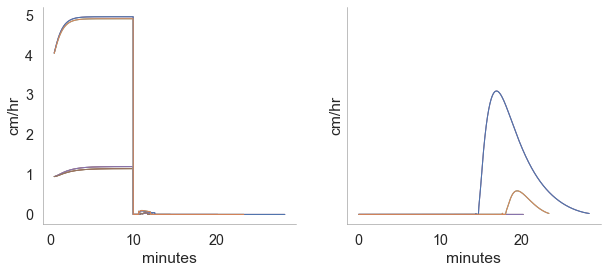

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)
fig = plot_inflowgraphs(core, trim = 30, nonzero = True, ax= axes[0])
fig = plot_hydrographs(core, nonzero = True, ax = axes[1])


In [31]:
sim = core.iloc[0]

In [32]:
 match_var = "dt_sw"

In [33]:
def plot_matched_hydrographs(core, match_var = "dt_sw", ):
    """
    Usage:
        fig1, fig2 = plot_matched_hydrographs(core)
    """
    match_vals = np.unique(core[match_var])
    match_to = match_vals[0]

    subset = core[core[match_var] == match_to]

    num_col = min(4, len(subset))
    num_row = int(np.ceil(len(subset) / 1. / num_col))

    figsize = (num_col * 4, num_row * 2.8)
    fig, axes = plt.subplots(num_row, num_col,
            figsize=figsize, sharey = True, sharex = True)
    plt.subplots_adjust(hspace=0.3)
    axes = axes.ravel()

    fig2, axes2 = plt.subplots(num_row, num_col,
        figsize=figsize, sharey = True, sharex = True)
    plt.subplots_adjust(hspace=0.2)
    axes2 = axes2.ravel()

    for i, ax in enumerate(axes[:len(subset)]):
        ax2 = axes2[i]
        key = subset.index[i]
        sim = subset.loc[key]
        ax.plot(sim.t_h/60., sim.flux3/sim.dx**0,
                label = "{0} = {1}".format(match_var, sim[match_var]))
        pretty = sim.pretty.split(", ")
        pretty = ','.join([a for a in pretty if match_var not in a])

        if len(pretty) > 20:
            pretty = pretty.split(",")
            pretty = "".join(pretty[:2]) + "\n"+ "".join(pretty[2:])
            ax.set_title(pretty)
        else:
            ax.set_title(pretty)
        
        for other_val in match_vals[1:]:

            params = extract_match_params(sim)
            params[match_var] = other_val
            matched_sim = filter_core(core, params).iloc[0]
            ax.plot(matched_sim.t_h/60, matched_sim.flux3/matched_sim.dx**0,
                label = "{0} = {1}".format(match_var, matched_sim[match_var]))

            tf = min(len(sim.flux3), len(matched_sim.flux3))
            numer =  (sim.flux3[:tf]/sim.dx**0 - matched_sim.flux3[:tf]/matched_sim.dx**0)
            denom = np.max(sim.flux3[:tf]/sim.dx**0)
            ax2.plot(sim.t_h[:tf]/60,
                    numer/denom*100,
                     label = "{0} = {1}".format(match_var, matched_sim[match_var]))

    for i, ax in enumerate(axes[len(subset):]):
        ax.set_visible(False)

    for i, ax2 in enumerate(axes2[len(subset):]):
        ax2.set_visible(False)

    axes[0].set_ylabel("m3/s")
    axes[4].set_ylabel("m3/s") if len(subset) > 4 else 0
    axes2[0].set_ylabel("% difference")
    axes2[4].set_ylabel("% difference") if len(subset) > 4 else 0

    axes[0].legend()
    axes2[0].legend()
    return fig, fig2


def extract_match_params(sim):
    """
    Return sim parameters in a dictionary

    """
    keys = ['q1_m2hr', 'Ks', 'dt_sw', 'tr', 'p', 'tmax_scale', 'dt_print',
            'save_fluxes', 'save_sve', 'dx',
            'veg_type', 'fV', 'grad_fV', 'seed', 'sigma_scale', 'sigma',
            'stripe_count', 'downslope', 'spots',
            'topo', 'So', 'imodel', 's_scale', 'theta_r', 'theta_s',
            'theta_i', 'H_i', 'Ao', 'scheme', 'alpha', 'alphaB',
            'itype1', 'itype3', 'itype2', 'itype4',  'epsh']

    params = {}
    for key in keys:
        if key in sim.keys():
            params[key] = sim[key]
    return params

## wtf units are these?

(<Figure size 1152x201.6 with 4 Axes>, <Figure size 1152x201.6 with 4 Axes>)

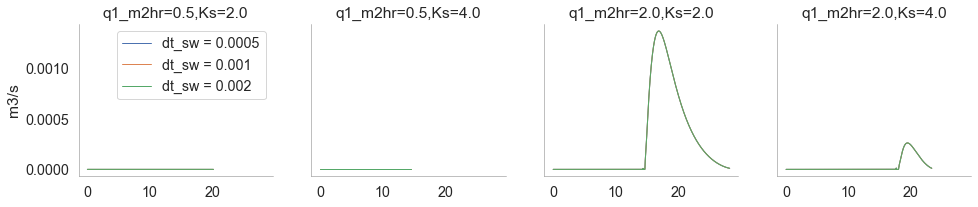

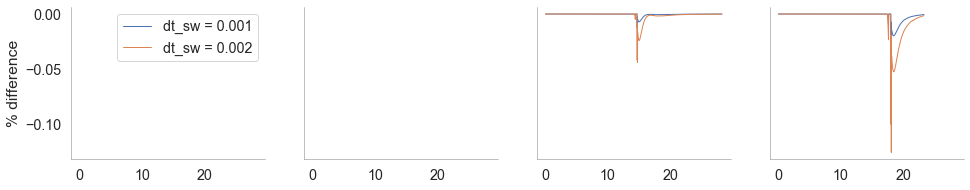

In [34]:
plot_matched_hydrographs(core, "dt_sw")

In [35]:
display(select_key)

Dropdown(description='Name:', options=(('q1_m2hr=0.5, Ks=2.0, dt_sw=0.0005', 'q1_m2hr-0.5/Ks-2.0,dt_sw-0.0005/…

In [37]:

key = select_key.value
print(key)
sim = core.loc[key]

q1_m2hr-0.5/Ks-2.0,dt_sw-0.0005/


q1_m2hr-0.5/Ks-2.0,dt_sw-0.0005/


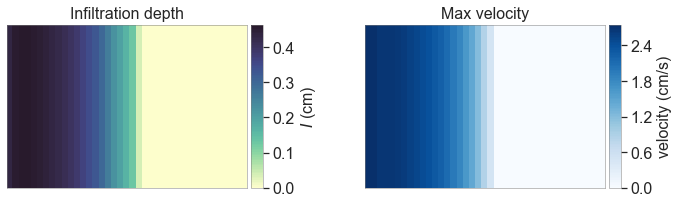

In [45]:

print (sim.name)
fig, axes = triptych(sim);


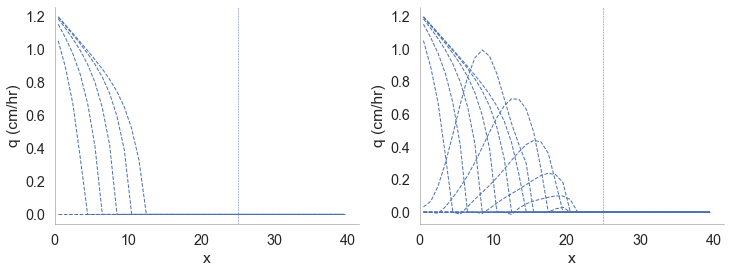

In [46]:
fig,axes = plt.subplots(1, 2, figsize = (12, 4))
fig, ax = plot_all_inflow(sim, t_f = sim.t_rain, freq = 10, label_axes=1, ax = axes[0])
fig, ax = plot_all_inflow(sim, t_f = sim.t_final, freq = 10, label_axes=1, ax = axes[1])

if "q1" in sim:
    axes[0].axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")
    axes[1].axvline(sim.q1/sim.ksatV, ls = "--", lw = 0.5, label = r"$L_{max}$")


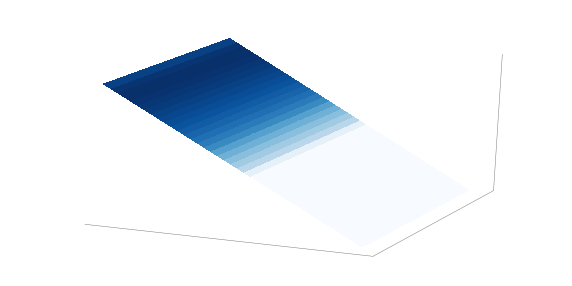

In [47]:
fig = plot_3D_infl(sim)